In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import networkx as nx

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from nmp.node import Node
from nmp.edge import Edge
from nmp.message_passer import MessagePasser
from nmp.state_updater import StateUpdater
from nmp.nmp_tools import get_lablesx, get_central_node, preprocess_graphx
from nmp.nmp_tools import run_message_passing, make_predictions, get_random_subgraphx

In [4]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

## Необходимые приготовления(признаки и архитектуры)

Первое: объявляем функции для извлечения признаков из вершин и рёбер.

In [5]:
from typing import Callable

def node_feature_exctractor(node, node_shape: int):
    return np.array(
                    [
                        (node['features']['SX'] - 50001) / (20 * 1293.),
                        (node['features']['SY'] - 40011) / (20 * 1293.),
                        (node['features']['SZ'] - 36850.5) / (1293 * 57),
                        node['features']['TX'],
                        node['features']['TY'],
                        (node['features']['chi2'] - 1.5) / 1.5
                    ] + (node_shape - 6) * [0.]
                )

def edge_feature_exctractor(edge_uv, edge_shape: int):
    return np.array(
                    [
                        edge_uv['features']['dsx'],
                        edge_uv['features']['dsy'],
                        edge_uv['features']['dsz'],
                        edge_uv['features']['dsxProjLeft'],
                        edge_uv['features']['dsyProjLeft'],
                        edge_uv['features']['dsxProjRight'],
                        edge_uv['features']['dsyProjRight'],
                        (edge_uv['features']['r'] - 200) / 200

                    ] + (edge_shape - 8) * [0.]
                )

Второе: объявляем нейронки для пересылки сообщений, обновления состояния и readout.

In [6]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.01)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(32, 32)
        self.nonlinear_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(32, 32)
        self.nonlinear_3 = nn.LeakyReLU()
        self.output = nn.Linear(32, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.nonlinear_2(self.layer_2(x))
        x = self.nonlinear_3(self.layer_3(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state
    
    
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module, device):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.device = device
        self.readout = readout(input, output).to(self.device)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 64)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(64, 32)

        self.mean = nn.Linear(32, output)
        self.sigma = nn.Linear(32, output)
        
    def forward(self, x):
        x = self.nonlinear_1(self.layer_1(x))
        x = self.layer_2(x)
        mean = self.mean(x)
        sigma = self.sigma(x)
        # mean = mean / (1 + mean.norm(dim=1, keepdim=True)**2).sqrt()
        # sigma = sigma / (1 + sigma.norm(dim=1, keepdim=True)**2).sqrt()
        return mean, sigma

In [7]:
device = torch.device('cpu')

## Инициализация функций

In [10]:
### shapes of nodes edges and messages
node_shape = 32 # tx, ty, chi2 + zeros
edge_shape = 32 # \delta_x \delta_y r
message_size = 32

### message passers for different steps
message_passer_first = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_second = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_third = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_forth = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)

message_passers = {
    0: message_passer_first,
    1: message_passer_second,
    2: message_passer_third,
    3: message_passer_forth
}

### state updater
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN, device=device) 

### readout function
readout = Readout(input=node_shape, output=3, readout=ReadoutNN, device=device)

In [11]:
class WeightedMessages(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.layer_1 = nn.Linear(input, 8)
        self.nonlinear_1 = nn.LeakyReLU()
        self.output = nn.Linear(8, 1)
    def forward(self, x):
        x = self.nonlinear_1(self.layer_1(x))
        return F.sigmoid(self.output(x))
    
wmessages = WeightedMessages(3).to(device)

Параметры засовываем в словарь, так проще.

## Загрузка данных

In [12]:
from glob import glob

In [13]:
files = glob('./data/brick_cleaned_*.pkl')[:1]

In [14]:
from tools.opera_tools import *

train_data = []

for file in files:
    print(file)
    graphx=nx.read_gpickle(file)
    graphx_connected_components = []
    degrees = nx.Graph(graphx).degree
    nodes_to_delete = []
    for node, degree in degrees:
        if degree == 0:
            nodes_to_delete.append(node)
    graphx.remove_nodes_from(nodes_to_delete)
    
    for connected_component in tqdm(nx.connected_components(nx.Graph(graphx)), leave=False):
        if len(connected_component) > 100:
            graphx_connected_components.append(graphx.subgraph(connected_component))
    for graphx_candidate in tqdm(graphx_connected_components, leave=False):
        lablesx_candidate = get_lablesx(graphx_candidate)
        if np.sum(np.unique(list(lablesx_candidate.values()), return_counts=True)[1][1:] > 150) > 1:
            train_data.append(nx.DiGraph(graphx_candidate))

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


./data/brick_cleaned_10.pkl


In [15]:
### optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(message_passer_third.message_passer.parameters()) + 
    list(wmessages.parameters()) + 
    list(readout.readout.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-3)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=3,
    margin=1.,
    device=device
)

Number of trainable parameters 32655


In [16]:
%%time
for graphx in train_data:
    preprocess_graphx(graphx, **params_mpnn)

CPU times: user 1min 10s, sys: 10.8 s, total: 1min 21s
Wall time: 1min 21s


In [ ]:
from tools.opera_tools import scattering_estimation_loss
for graphx in train_data:
    weights = []
    for i, j, edge in tqdm(graphx.edges(data=True), leave=False):
        energy, likelihood = scattering_estimation_loss(graphx.node[i], graphx.node[j])
        weights.append([(edge['features']['r'] - 200) / 200, 
                        (energy - 462.) / 1258., 
                        -(likelihood + 17) / 20])
    graphx.graph['E_weights'] = torch.tensor(weights, requires_grad=False, dtype=torch.float32)

 42%|████▏     | 178434/428661 [00:04<00:06, 36856.81it/s]

In [ ]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [ ]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [ ]:
def laplacian_clusters(nodes_predictions, true_labels):
    nodes_medians, nodes_log_b = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if (true_labels==label).sum() < 100: continue
            
        labeled_medians = nodes_medians[true_labels==label]
        labeled_log_b = nodes_log_b[true_labels==label]
        median = labeled_medians.median(dim=0)[0]
        b = torch.abs(labeled_medians - median).mean(dim=0) + (labeled_log_b.exp() * torch.exp(-torch.abs(labeled_medians - median) / labeled_log_b.exp())).mean(dim=0)
        clusters[label] = {
            'median': median, # 
            'b': b
        }
    
    return clusters


def gaussian_clusters(nodes_predictions, true_labels):
    nodes_means, nodes_log_std = nodes_predictions
    
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if (true_labels==label).sum() < 100: continue
        
        labeled_means = nodes_means[(true_labels==label).astype(int)]
        labeled_log_std = nodes_log_std[(true_labels==label).astype(int)]
        
        mean = labeled_means.mean(dim=0)
        std = (labeled_means.std(dim=0).pow(2) + (2. * labeled_log_std).exp().mean(dim=0)).sqrt()
        clusters[label] = {
            'mean': mean,
            'std': std
        }
    del nodes_log_std, nodes_means
    return clusters

In [ ]:
def loss_similar_laplacian_mean_div(nodes_predictions, true_labels, clusters):
    nodes_medians, nodes_log_b = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = nodes_medians[true_labels==label]
        l = (labeled_medians - clusters[label]['median'].detach()).pow(2)
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_mean_div(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).pow(2)
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss / 2

In [ ]:
def pairwise_distances(x, y = None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    # if y is None:
    #     dist = dist - torch.diag(dist.diag)
    return torch.clamp(dist, 0.0, np.inf)

def make_contrastive_loss(nodes_predictions, true_labels, margin=1., **kwargs):
    nodes_predictions = nodes_predictions[0]
    loss = 0.
    p = pairwise_distances(nodes_predictions)
    unique_labels = np.unique(true_labels).astype(float)
    N = len(nodes_predictions)
    for i in range(len(unique_labels)):
        for j in range(i + 1):
            if unique_labels[i] == 0. or unique_labels[j] == 0:
                continue
            if i == j:
                loss = loss + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]].sum()
            else:
                loss = loss + torch.relu(margin - (1e-4 + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]]).sqrt()).pow(2).sum()
                

                    
    return loss / (N * (N - 1))

In [ ]:
def run_message_passing(graphx, params_mpnn):
    device = params_mpnn['device']
    true_labels = graphx.graph['true_labels']
    
    for i, node in graphx.nodes(data=True):
        node_torch = node['node_torch']
        node_torch.reset()
    
    X_nodes = graphx.graph['X_nodes'].to(device)
    X_edges = graphx.graph['X_edges'].to(device)
    X_weights = graphx.graph['E_weights'].to(device)
    
    for step in range(3):
        messages = graphx.graph['message_passers'][step].message_passer(
            torch.cat([X_nodes[graphx.graph['X_nodes_out']], 
                       X_nodes[graphx.graph['X_nodes_in']], 
                       X_edges], dim=1)
        )
        messages = params_mpnn['wmessages'](X_weights) * messages
        messages_aggregated_in = []
        messages_aggregated_out = []
        for i, node in graphx.nodes(data=True):
            messages_aggregated_in.append(
                node_torch.state_updater.aggregate_messages(messages[node_torch.edges_in])
            )

            messages_aggregated_out.append(
                node_torch.state_updater.aggregate_messages(messages[node_torch.edges_out])
            )

        X_node = node_torch.state_updater.state_updater(
            torch.cat([torch.cat(messages_aggregated_out), torch.cat(messages_aggregated_in)], dim=1), 
            X_nodes
        )

    means, sigmas = readout.readout(X_nodes)

    for i, node in graphx.nodes(data=True):
        node_torch = node['node_torch']
        node_torch.reset()
    return means, sigmas

In [ ]:
### optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(message_passer_third.message_passer.parameters()) + 
    list(message_passer_forth.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(wmessages.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-3)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=4,
    margin=2.,
    wmessages=wmessages,
    device=device
)

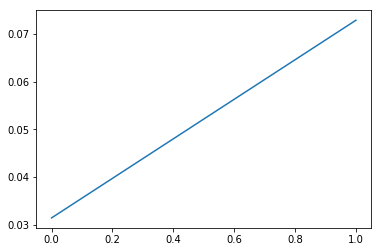

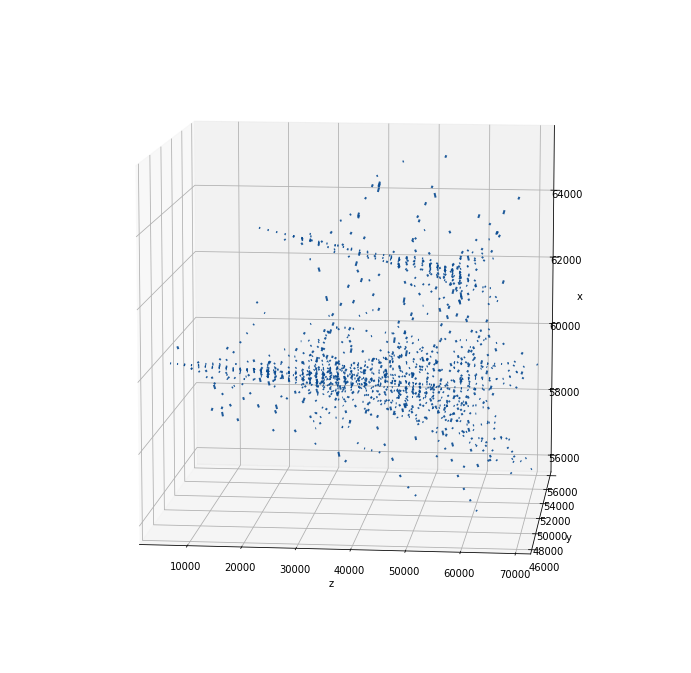

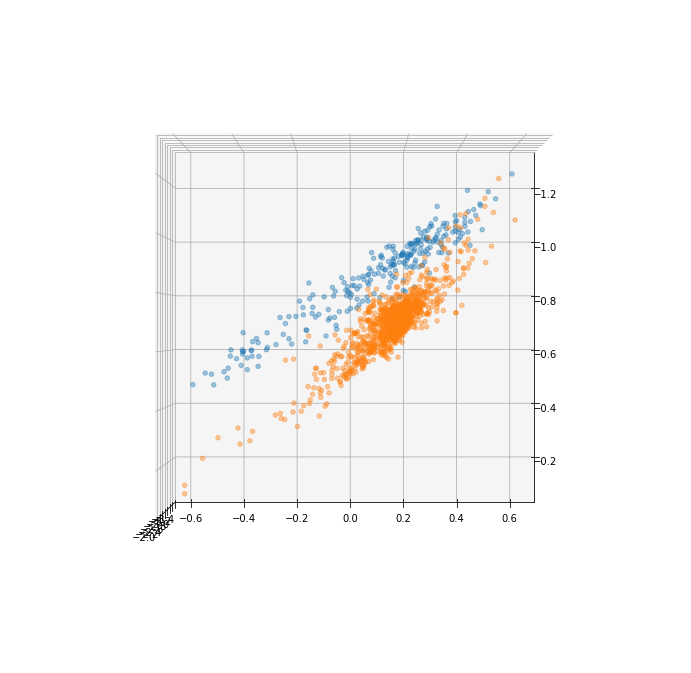

  0%|          | 2/1000 [00:03<32:44,  1.97s/it]

KeyboardInterrupt: 

In [126]:
%%time
losses = []
for _ in tqdm(range(1000)):
    graphx = np.random.choice(train_data)
    true_labels = graphx.graph['true_labels']
    
    means, sigmas = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)

    clusters = laplacian_clusters((means, sigmas), true_labels)
    #l1 = loss_similar_laplacian_mean_div((means, sigmas), true_labels, clusters)
    #l2 = loss_distinct_laplacian_mean_div(clusters)
    loss = make_contrastive_loss((means, sigmas), true_labels)#l1 + l2
    #loss = l1 + l2
    
    optimizer_params.zero_grad()
    loss.backward()
    optimizer_params.step()
    
    clear_output()
    
    
    losses.append(loss.item())
    plt.plot(losses)
    plt.show()
    plot_graphx(graphx)
    plot_clusters(means, true_labels, azim=0, elev=90)

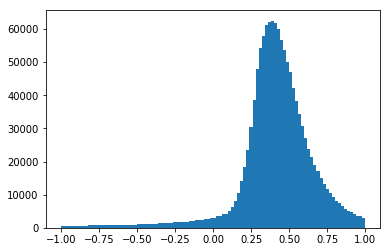

In [63]:
plt.hist(R[S==1], bins=100, density=True, alpha=0.5);
plt.hist(R[S==0], bins=100, density=True, alpha=0.5);

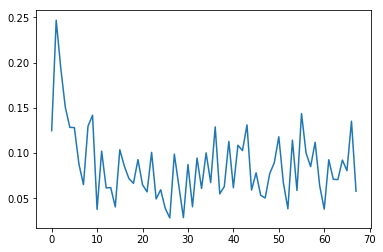

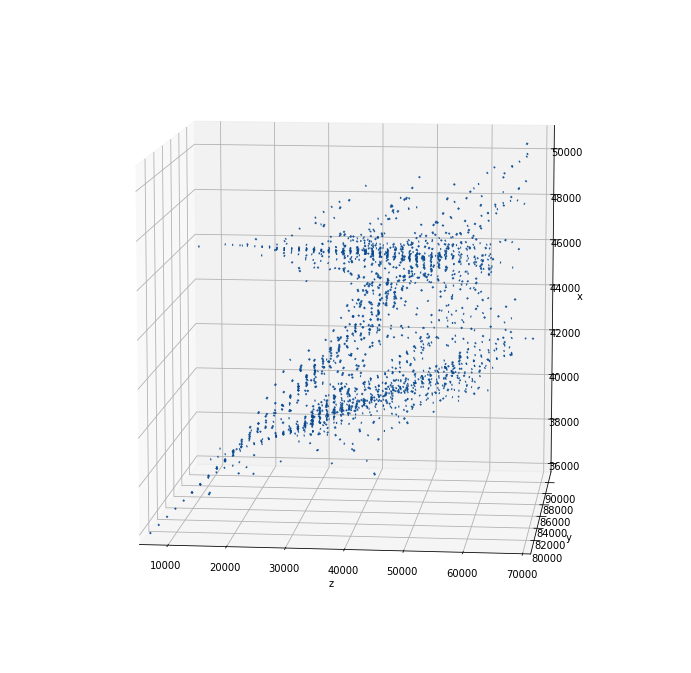

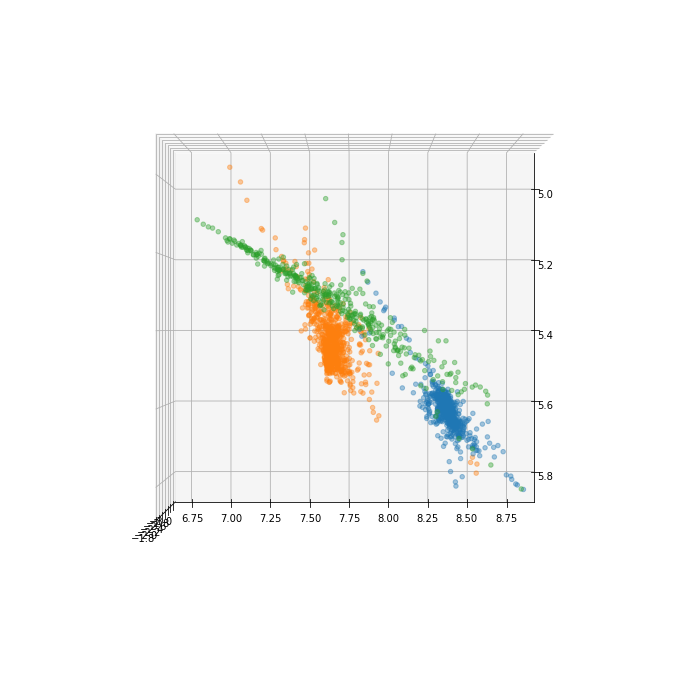

In [82]:
graphx = np.random.choice(train_data)
true_labels = graphx.graph['true_labels']

means, sigmas = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)

clusters = laplacian_clusters((means, sigmas), true_labels)
#l1 = loss_similar_laplacian_mean_div((means, sigmas), true_labels, clusters)
#l2 = loss_distinct_laplacian_mean_div(clusters)
loss = make_contrastive_loss((means, sigmas), true_labels)#l1 + l2
#loss = l1 + l2

losses.append(loss.item())
plt.plot(losses)
plt.show()
plot_graphx(graphx)
plot_clusters(means, true_labels, azim=0, elev=90)

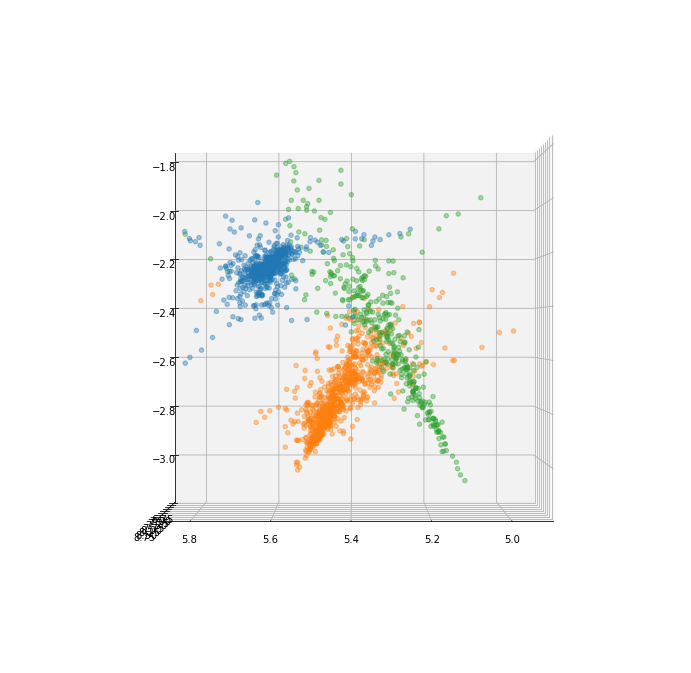

In [86]:
plot_clusters(means, true_labels, azim=90, elev=0)

In [87]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

X = means.cpu().detach().numpy()
# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, n_iter=3000)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

t-SNE: 1.8e+02 sec


In [88]:
colors = true_labels.numpy()

In [89]:
tsne.n_iter_

2999

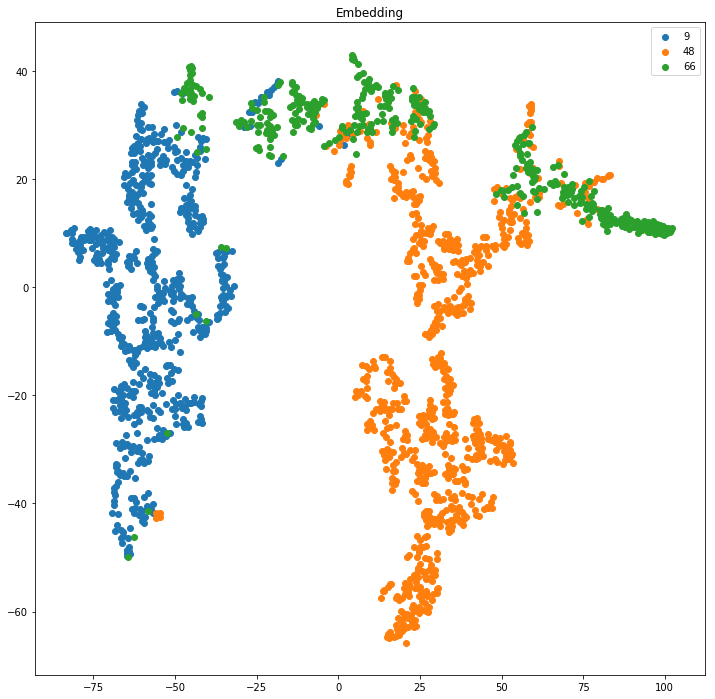

In [90]:
plt.figure(figsize=(12, 12))
for color in np.unique(colors):
    if color == 0:continue
    plt.scatter(trans_data[0][colors == color], trans_data[1][colors == color], cmap=plt.cm.rainbow, label=color)
plt.title("Embedding" )
plt.axis('tight')
plt.legend()
plt.show()

In [19]:
def laplacian_clusters(nodes_predictions, true_labels):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_means)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if np.sum(true_labels==label) < 100: continue
        labeled_medians = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_b = torch.stack(list(nodes_log_b[true_labels==label]))
        median = labeled_medians.median(dim=0)[0]
        b = torch.abs(labeled_medians - median).mean(dim=0) + (labeled_log_b.exp() * torch.exp(-torch.abs(labeled_medians - mean) / labeled_log_std.exp())).mean(dim=0)
        clusters[label] = {
            'median': median, # 
            'b': b
        }
        
    return clusters

def loss_similar_laplacian_mean_div(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_means)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_b = torch.stack(list(nodes_log_b[true_labels==label]))
        
        l = (labeled_medians - clusters[label]['median'].detach()).pow(2)
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_mean_div(clusters, margin=1.):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_means)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).pow(2)
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss


def loss_similar_laplacian_median_div(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_means)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_b = torch.stack(list(nodes_log_b[true_labels==label]))
        
        l = (labeled_medians - clusters[label]['median'].detach()).abs()
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_median_div(clusters, margin=1.):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_means)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).abs()
            l = torch.relu(margin - l.sum()).mean()
            loss = loss + l
    return loss

In [20]:
def gaussian_clusters(nodes_predictions, true_labels):
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    labels = np.unique(true_labels)
    
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if np.sum(true_labels==label) < 100: continue
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))
        mean = labeled_means.mean(dim=0)
        std = (labeled_means.std(dim=0).pow(2) + (2. * labeled_log_std).exp().mean(dim=0)).sqrt()
        clusters[label] = {
            'mean': mean,
            'std': std
        }
        
    return clusters


def loss_similar_gaussian_mean_div(nodes_predictions, true_labels, clusters):
    """
    Classical loss ||m_i - m_cluster||_2
    """
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    
    loss = 0.
    for label in clusters.keys():
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))
        
        l = (labeled_means - clusters[label]['mean'].detach()).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_gaussian_mean_div(clusters, margin=1.):
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss

def loss_similar_gaussian_median_div(nodes_predictions, true_labels, clusters):
    """
    Classical loss ||m_i - m_cluster||_2
    """
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    
    loss = 0.
    for label in clusters.keys():
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))
        
        l = (labeled_means - clusters[label]['mean'].detach()).abs() # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_gaussian_median_div(clusters, margin=1.):
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).abs() # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
            l = torch.relu(margin - l.sum())
            loss = loss + l
    return loss

def loss_similar_kl(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    loss = 0.
    for label in clusters.keys():
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))

        l = clusters[label]['std'].log() - labeled_log_std

        l = l + (labeled_log_std.exp().pow(2) + 
                 (labeled_means - clusters[label]['mean']).pow(2)) / (2. * clusters[label]['std'].pow(2))
        loss = loss + l.sum(dim=1).mean()
    return loss

def loss_similar_kl_inv(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    loss = 0.
    for label in clusters.keys():
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))

        l = labeled_log_std - clusters[label]['std'].log()

        l = l + (clusters[label]['std'].pow(2) + (labeled_means - 
                                              clusters[label]['mean']).pow(2)) / (2. * labeled_log_std.exp().pow(2))
        loss = loss + l.sum(dim=1).mean()
    return loss

def loss_similar_kl_sim(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    nodes_means = np.array(nodes_means)
    nodes_log_std = np.array(nodes_log_std)
    loss = 0.
    for label in clusters.keys():
        labeled_means = torch.stack(list(nodes_means[true_labels==label]))
        labeled_log_std = torch.stack(list(nodes_log_std[true_labels==label]))
        # log (\sigma_1 / \sigma_2)
        l = (clusters[label]['std'].pow(2) + (labeled_means - 
                                          clusters[label]['mean']).pow(2)) / (2. * labeled_log_std.exp().pow(2))
        # 
        l = l + (labeled_log_std.exp().pow(2) + (labeled_means - 
                                                clusters[label]['mean']).pow(2)) / (2. * clusters[label]['std'].pow(2))
        loss = loss + l.sum(dim=1).mean()
    return loss

def loss_distinct_kl_sim(clusters):
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['std'].pow(2) - 
                 (clusters[label_2]['mean'] - clusters[label_1]['mean']).pow(2)) / (2. * clusters[label_1]['std'].pow(2))
            l = l + (clusters[label_1]['std'].pow(2) - 
                     (clusters[label_2]['mean'] - clusters[label_1]['mean']).pow(2)) / (2. * clusters[label_2]['std'].pow(2))
            loss = loss + torch.relu(margin - l.sum())
            
    return loss

In [21]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = [node_prediction.detach().numpy() for 
                         node_prediction in nodes_predictions]
    nodes_predictions = np.array(nodes_predictions)
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0] + np.random.randn(l) / 100,
            nodes_predictions[true_labels==cluster_id, 1] + np.random.randn(l) / 100,
            nodes_predictions[true_labels==cluster_id, 2] + np.random.randn(l) / 100,
            alpha=0.4
        )
        
    plt.show()
    
def train_step(graphx, lablesx, optimizer_params, **params_mpnn):
    # reset
    for _, node in graphx.nodes(data=True):
        node['node_torch'].reset()
        
    # execute several steps of message passing with updates
    for step in range(params_mpnn['steps']):
        run_message_passing(graphx, step=step)

    # make predictions
    nodes_predictions, true_labels = make_predictions(graphx, **params_mpnn)

    # reset
    for _, node in graphx.nodes(data=True):
        node['node_torch'].reset()
    
    return nodes_predictions, true_labels

In [30]:
optimizer_params.param_groups[0]['lr'] = 1e-2

In [95]:
wmessages(graphx.graph['weights'])

tensor([[ 4.1560e-39],
        [ 2.2976e-16],
        [ 4.1560e-39],
        ...,
        [ 1.0000e+00],
        [ 1.0000e+00],
        [ 2.1464e-33]])

In [23]:
for graphx in train_data:
    preprocess_graphx(graphx, **params_mpnn)

In [28]:
from collections import defaultdict

def plot_losses(losses):
    for key in losses:
        plt.plot(losses[key])
    plt.show()
    
losses = defaultdict(list)

defaultdict(<class 'list'>, {19: [array(5.9378166, dtype=float32), array(5.901372, dtype=float32), array(3.9637644, dtype=float32), array(2.9911036, dtype=float32), array(2.9294522, dtype=float32)], 3: [array(11.725543, dtype=float32), array(5.3296027, dtype=float32), array(4.9668956, dtype=float32), array(2.7856522, dtype=float32), array(2.116275, dtype=float32), array(2.0776408, dtype=float32)], 32: [array(1.8625995, dtype=float32), array(1.8039573, dtype=float32), array(0.66244143, dtype=float32)], 15: [array(1.9856986, dtype=float32), array(1.9580033, dtype=float32), array(1.6964368, dtype=float32), array(1.384556, dtype=float32)], 18: [array(1.9374652, dtype=float32), array(1.9129673, dtype=float32), array(1.5860981, dtype=float32), array(0.27014846, dtype=float32), array(0.22456552, dtype=float32), array(0.30150348, dtype=float32), array(0.28764725, dtype=float32), array(0.27283472, dtype=float32), array(0.26374716, dtype=float32), array(0.26260516, dtype=float32), array(0.248465

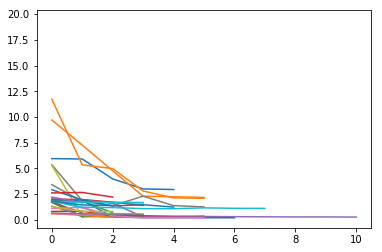

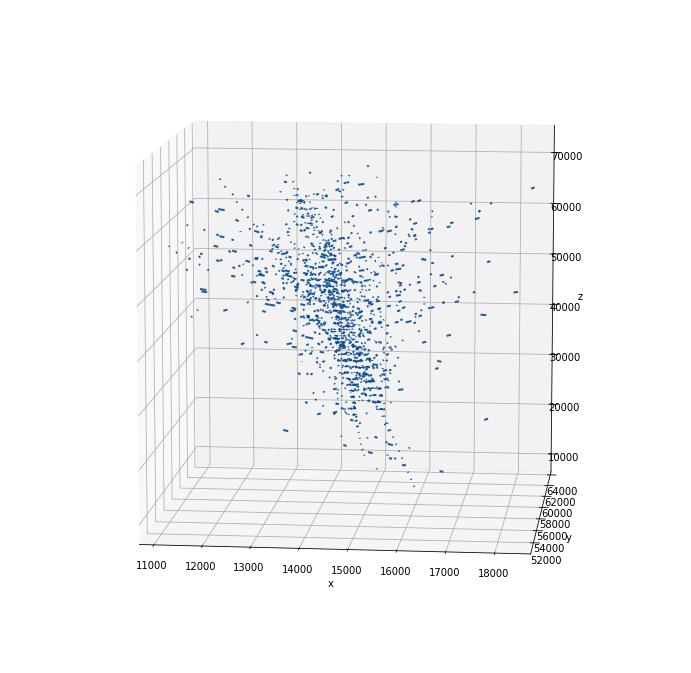

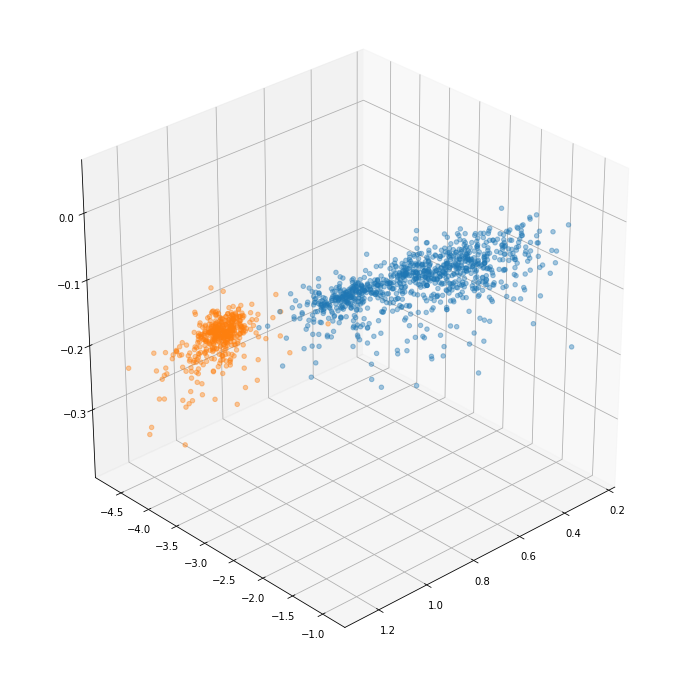

  5%|▌         | 52/1000 [5:06:30<93:07:50, 353.66s/it]

KeyboardInterrupt: 

In [31]:
from IPython.display import clear_output
from math import log
for i in tqdm(range(1000)):
    k = np.random.choice(len(train_data))
    nodes_predictions, true_labels = train_step(
        graphx=train_data[k],
        lablesx=get_lablesx(train_data[k]),
        **params_mpnn
    )
        
    clusters = gaussian_clusters(nodes_predictions, true_labels)
    loss = (
        loss_similar_gaussian_mean_div(nodes_predictions, true_labels, clusters) + 
        loss_distinct_gaussian_mean_div(clusters, margin=1.)
    )
    #loss = loss_similar_gaussian_wasserstein(nodes_predictions, true_labels, clusters) * c
    optimizer_params.zero_grad()
    loss.backward()
    optimizer_params.step()
    
    #clear_output()
    losses[k].append(loss.detach().numpy())
    clear_output()
    print(loss)
    print(losses)
    print(k)
    nodes_means, nodes_log_std = list(zip(*nodes_predictions))
    plot_losses(losses)
    plot_graphx(train_data[k])
    plot_clusters(nodes_means, true_labels)
    # plot_clusters(nodes_log_std, true_labels)

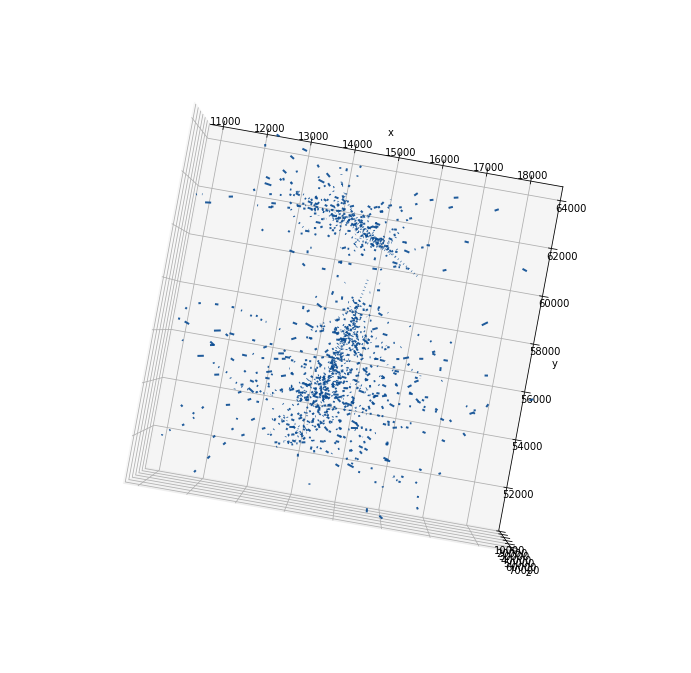

In [36]:
plot_graphx(train_data[29], elev=90)

## Лосс функция

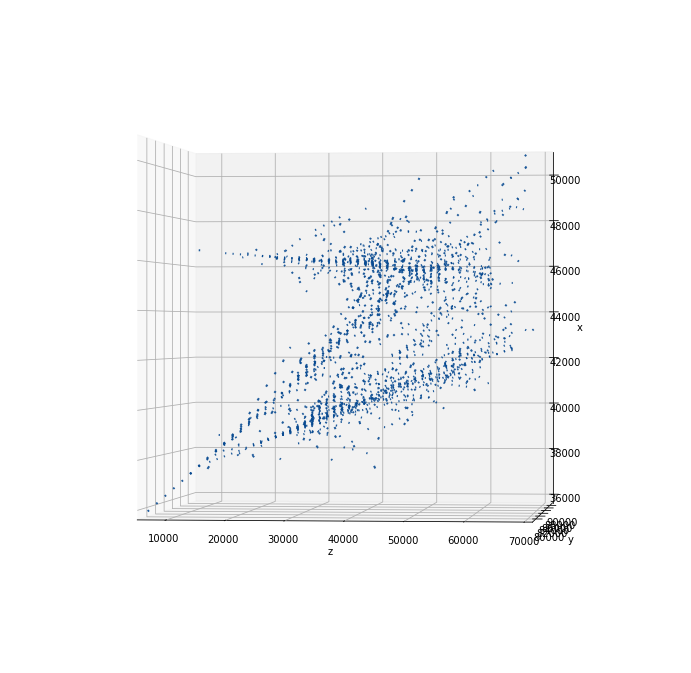

In [83]:
plot_graphx(graphx, elev=0)

In [17]:
def make_contrastive_loss(nodes_predictions, true_labels, margin=1., **kwargs):
    losses = []
    for i in tqdm(range(len(nodes_predictions))):
        for j in range(i):
            euclidean_distance = F.pairwise_distance(nodes_predictions[i][None, :], 
                                                     nodes_predictions[j][None, :])[0]
            if true_labels[i]==true_labels[j] and euclidean_distance > 1e-1:
                losses.append(euclidean_distance**2)
            else:
                loss = torch.relu(margin - euclidean_distance)**2
                if loss > 1e-3:
                    losses.append(loss)
                    
    return torch.stack(losses).mean()